# Aligning partially matched, serial, single-cell resolution breast cancer spatial transcriptomics data from Xenium

In this notebook, we take two single cell resolution spatial transcriptomics datasets of serial breast cancer sections profiled by the Xenium technology and align them to each other. See the bioRxiv preprint for more details about this data: https://www.biorxiv.org/content/10.1101/2022.10.06.510405v2 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import STalign

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

We have already downloaded single cell spatial transcriptomics data from and placed the files in a folder called `xenium_data`: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [2]:
# Single cell data 1
# read in data
fname = 'xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

   cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts  \
0        1  377.663005  843.541888                154                     0   
1        2  382.078658  858.944818                 64                     0   
2        3  319.839529  869.196542                 57                     0   
3        4  259.304707  851.797949                120                     0   
4        5  370.576291  865.193024                120                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0           154  110.361875     45.562656  
1                        0            64   87.919219     24.248906  
2                        0            57   52.561875     23.526406  
3                        0           120   75.230312     35.176719  
4                        0           120  180.218594     34.499375  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

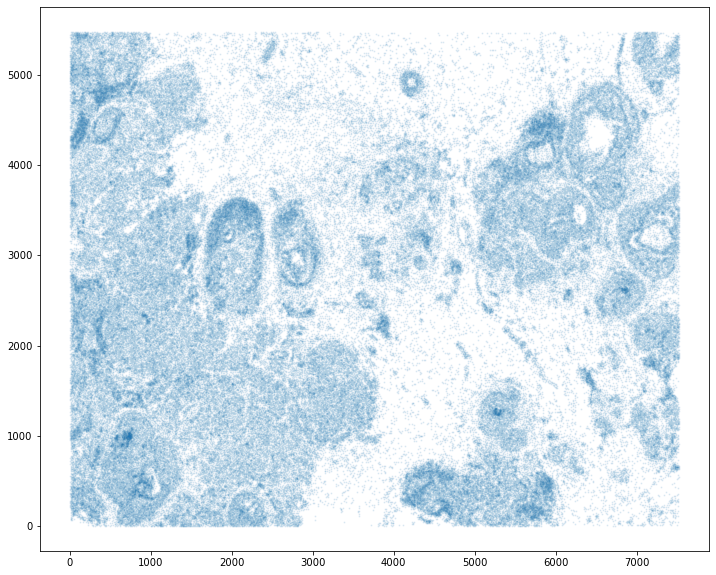

In [3]:
# get cell centroid coordinates
xI = np.array(df1['x_centroid'])
yI = np.array(df1['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1)

We will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 167782
10000 of 167782
20000 of 167782
30000 of 167782
40000 of 167782
50000 of 167782
60000 of 167782
70000 of 167782
80000 of 167782
90000 of 167782
100000 of 167782
110000 of 167782
120000 of 167782
130000 of 167782
140000 of 167782
150000 of 167782
160000 of 167782
167781 of 167782


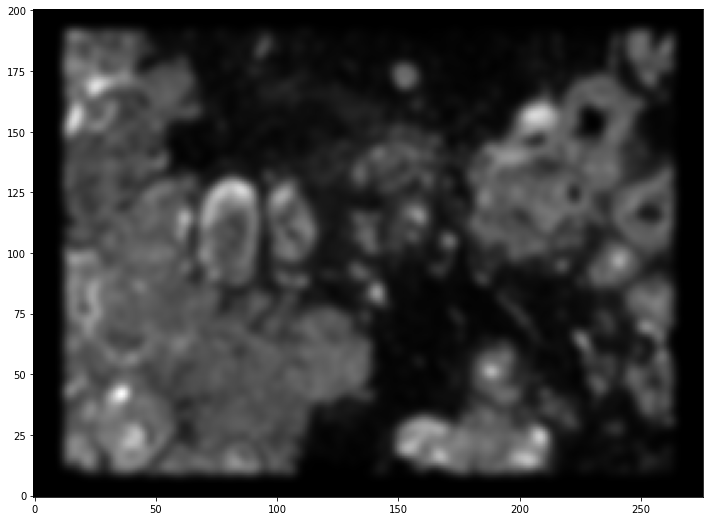

In [4]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Now, we can repeat this for the cell information from the second dataset.

0 of 118752
10000 of 118752
20000 of 118752
30000 of 118752
40000 of 118752
50000 of 118752
60000 of 118752
70000 of 118752
80000 of 118752
90000 of 118752
100000 of 118752
110000 of 118752
118751 of 118752


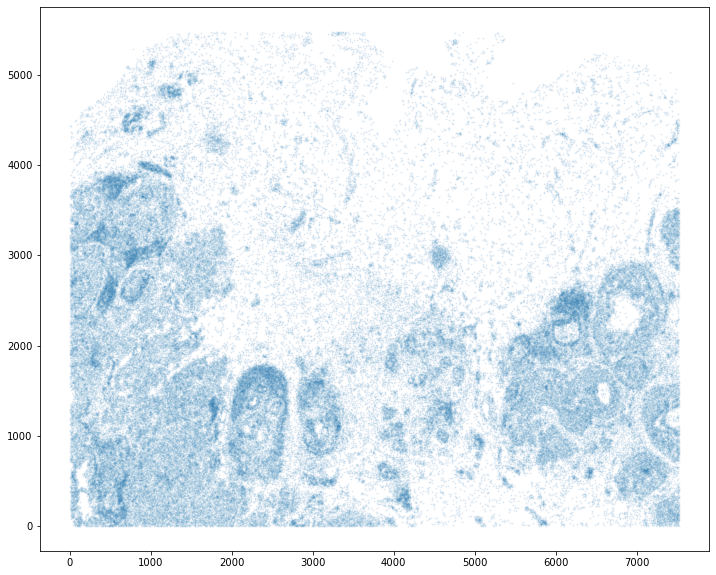

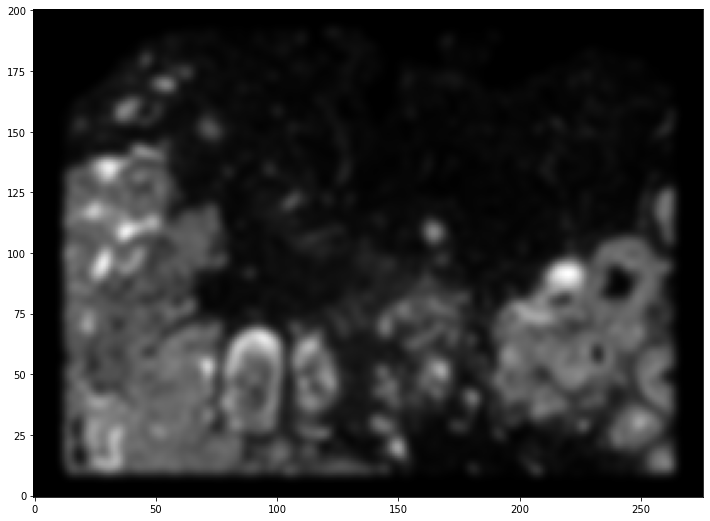

In [5]:
# Single cell data 2
# read in data
fname = 'xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep2_cells.csv.gz'
df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2['x_centroid'])
yJ = np.array(df2['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.1)

# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=30)
ax = fig.axes[0]
ax.invert_yaxis()

`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. So we can manually designate a few landmark points to help initialize the alignment. A `curve_annotator.py` script is provided to assist with this. In order to use the `curve_annotator.py` script, we will need to write out our images as `.npz` files. 

In [6]:
# Optional: write out npz files for landmark point picker
np.savez('sample1', x=XI,y=YI,I=I)
np.savez('sample2', x=XJ,y=YJ,I=J)
# outputs sample1.npz and sample2.npz

Given these `.npz` files, we can then run the following code:
    
```
python curve_annotator.py sample1.npz
python curve_annotator.py sample2.npz
```

Which will provide a graphical user interface to selecting landmark points, which will then be saved in `sample1_curves.npy` and `sample2_curves.npy` respectively. We can then read in these files. 

In [7]:
# read from file
pointsIlist = np.load('sample1_curves.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('sample2_curves.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'0': [(2065.0390375683187, 3096.538441761356)], '1': [(6505.52290853606, 4365.248119180711)], '2': [(4226.85355369735, 4932.828764342001)]}
{'0': [(2365.8569852416354, 1218.8582693193312)], '1': [(6839.7279529835705, 2387.4066564161058)], '2': [(4552.711823951313, 3046.801817706428)]}


Note that these landmark points are read in as lists. We will want to convert them to a simple array for downstream usage. 

In [8]:
# convert to array
pointsI = []
pointsJ = []

# Jean's note: a bit odd to me that the points are stored as y,x
## instead of x,y but all downstream code uses this orientation
for i in pointsIlist.keys():
    pointsI.append([pointsIlist[i][0][1], pointsIlist[i][0][0]])
for i in pointsJlist.keys():
    pointsJ.append([pointsJlist[i][0][1], pointsJlist[i][0][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

In [9]:
# now arrays
print(pointsI)
print(pointsJ)

[[3096.53844176 2065.03903757]
 [4365.24811918 6505.52290854]
 [4932.82876434 4226.8535537 ]]
[[1218.85826932 2365.85698524]
 [2387.40665642 6839.72795298]
 [3046.80181771 4552.71182395]]


Alternatively, you can also just manually create an array of points.

But it will be good to double check that your landmark points look sensible by plotting them along with the rasterized image we created.

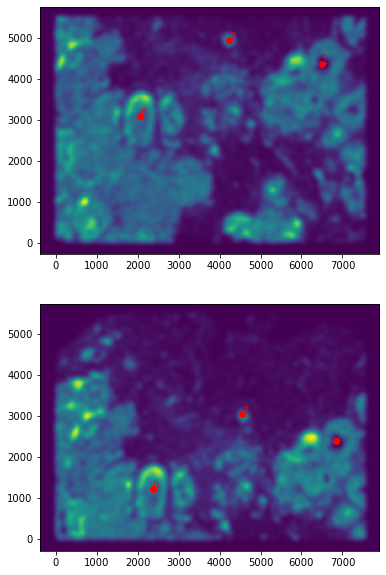

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) # just want 201x276 matrix
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) # just want 201x276 matrix
# with points
ax[0].scatter(pointsI[:,1], pointsI[:,0], c='red')
ax[1].scatter(pointsJ[:,1], pointsJ[:,0], c='red')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')
ax[0].invert_yaxis()
ax[1].invert_yaxis()

We can now initialize a simple affine alignment from the landmark points. 

In [11]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI, pointsJ)

Depending on distortions in the tissue sample (as well as the accuracy of your landmark points), a simple affine alignment may not be sufficient to align the two single-cell spatial transcriptomics datasets. So we will need to perform non-linear local alignments via LDDMM. 

There are many parameters that can be tuned for performing this alignment. 

/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525474122/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/jeanfan/Desktop/JEFworks_STalign/STalign/STalign.py:1283: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


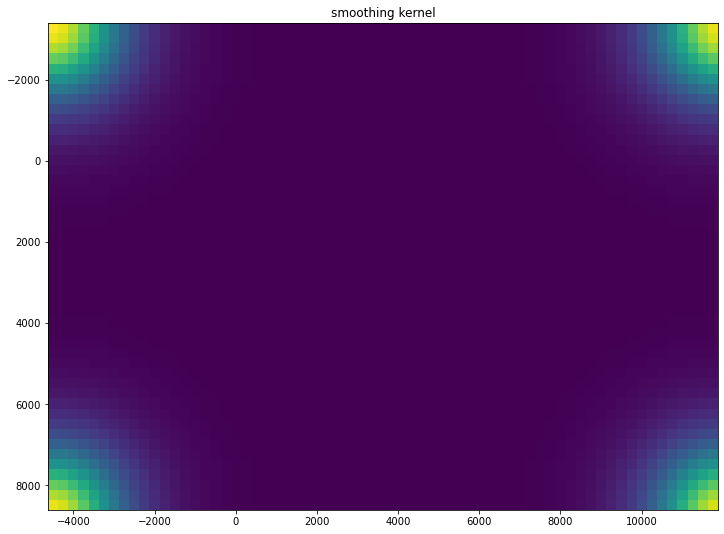

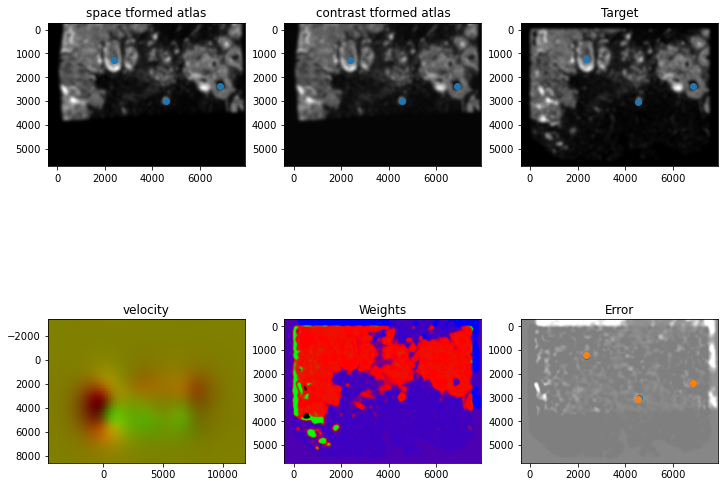

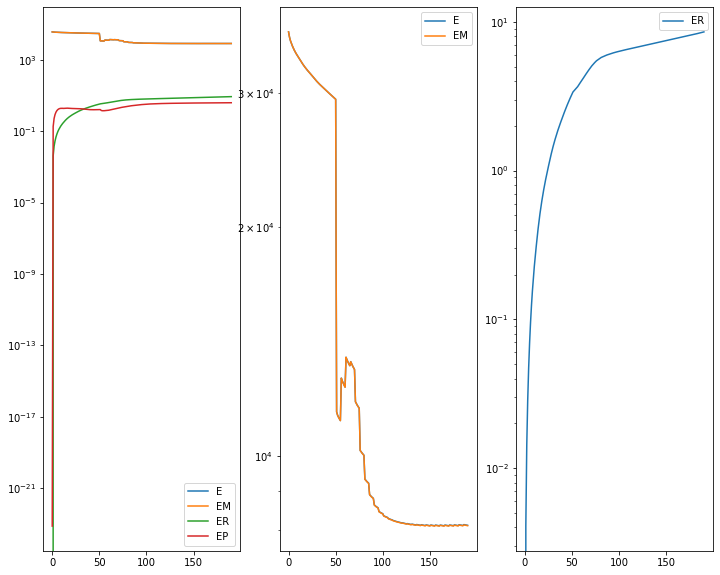

In [12]:
# run LDDMM
# running this on my desktop so cpu device
device = 'cpu' 

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':200,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':1.5,
          'sigmaB':1.0,
          'sigmaA':1.5,
          'epV': 100
          }

Ifoo = np.vstack((I, I, I))
Jfoo = np.vstack((J, J, J))
A,v,xv = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

/Users/jeanfan/Desktop/JEFworks_STalign/STalign/STalign.py:1638: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/jeanfan/Desktop/JEFworks_STalign/STalign/STalign.py:1639: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
/Users/jeanfan/Desktop/JEFworks_STalign/STalign/STalign.py:1651: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


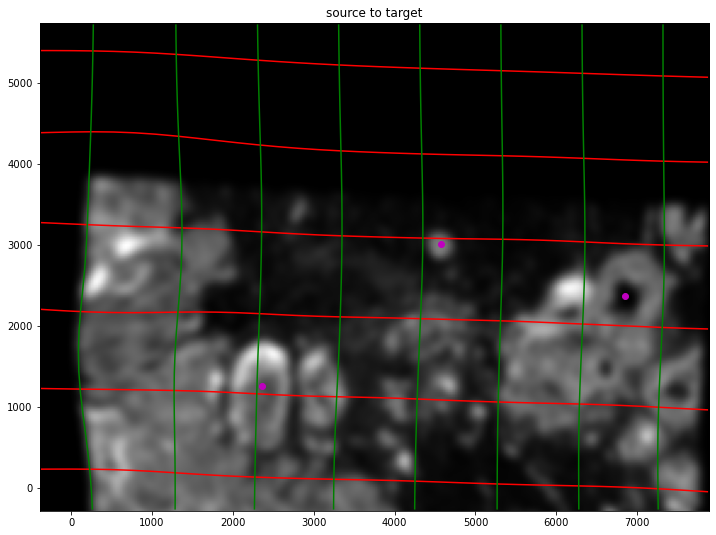

In [13]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ])
phipointsI = STalign.transform_points_atlas_to_target(xv,v,A,pointsI)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phipointsI[:,1].detach(),phipointsI[:,0].detach(),c="m")
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

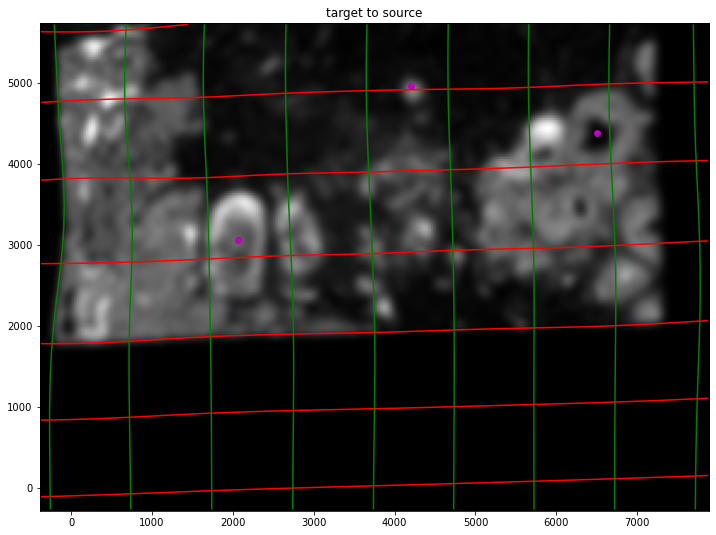

In [14]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])
phiipointsJ = STalign.transform_points_target_to_atlas(xv,v,A,pointsJ)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")
ax.invert_yaxis()

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [15]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, np.stack([yJ, xJ], 1))

# just original points for visualizing later
tpointsI = np.stack([xI, yI]) 

And we can visualize the results.

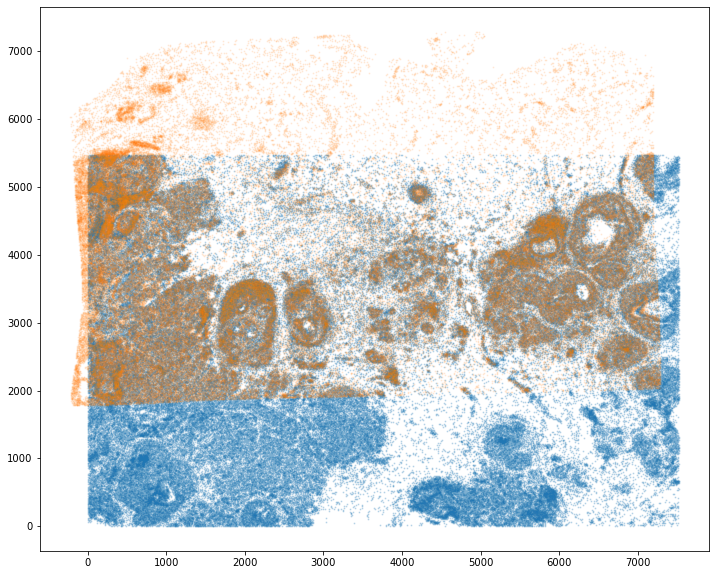

In [16]:
# plot results
fig,ax = plt.subplots()
ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.2) 
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.1) # also needs to plot as y,x not x,y

And save the new aligned positions by appending to our original data using `numpy` with `np.hstack` and save the output as a new csv file with `np.savetxt`.

In [17]:
# save results by appending
# note results are in y,x coordinates
results = np.hstack((df2, tpointsJ.numpy()))
np.savetxt('sample2_STalign.csv', results, delimiter=',')